<a href="https://colab.research.google.com/github/aanchal-n/Coursera_Capstone/blob/master/predicting_social_distancing_friendly_restaurants_NY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREDICTION OF SOCIAL DISTANCING FRIENDLY RESTAURANTS IN NEW YORK CITY

The below project is to extract some of the most social distancing friendly restaurants in new york city. The criteria for segregation such as Outdoor Seating, Parking and Reservations are entirely based off of CDC's considerations for restaurants and bars. This system purely works on data segregation, listing and visualisation

DATA COLLECTION

Importing all necessary packages.
We use pandas for loading and cleaning
data.
We use json to extract data from json files on different websites .
We use requests to scrape datasets from various sources to contribute to better segregation of data.
We use folium to plot the locations of datapoints at the end.

In [2]:
import numpy as np
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import sklearn.cluster as Kmeans
import folium
import lxml.html as lh
from PIL import Image

We extract a newyork json file with the list of all the boroughs and the neighbourhoods in them as well as their latitude and longitude. This json file is converted to a dataframe with the name of the boroughs, neighbourhoods, Latitude and Longitude

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
newyork_data

{'bbox': [-74.2492599487305,
  40.5033187866211,
  -73.7061614990234,
  40.9105606079102],
 'crs': {'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}, 'type': 'name'},
 'features': [{'geometry': {'coordinates': [-73.84720052054902,
     40.89470517661],
    'type': 'Point'},
   'geometry_name': 'geom',
   'id': 'nyu_2451_34572.1',
   'properties': {'annoangle': 0.0,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661],
    'borough': 'Bronx',
    'name': 'Wakefield',
    'stacked': 1},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.82993910812398, 40.87429419303012],
    'type': 'Point'},
   'geometry_name': 'geom',
   'id': 'nyu_2451_34572.2',
   'properties': {'annoangle': 0.0,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.874294193

In [4]:
neighborhood_data=newyork_data["features"]
column_name = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_name)
for data in neighborhood_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods

Borough  Neighborhood   Latitude  Longitude
0            Bronx     Wakefield  40.894705 -73.847201
1            Bronx    Co-op City  40.874294 -73.829939
2            Bronx   Eastchester  40.887556 -73.827806
3            Bronx     Fieldston  40.895437 -73.905643
4            Bronx     Riverdale  40.890834 -73.912585
..             ...           ...        ...        ...
301      Manhattan  Hudson Yards  40.756658 -74.000111
302         Queens       Hammels  40.587338 -73.805530
303         Queens     Bayswater  40.611322 -73.765968
304         Queens  Queensbridge  40.756091 -73.945631
305  Staten Island     Fox Hills  40.617311 -74.081740

[306 rows x 4 columns]

We extract the current number of active covid cases per borough. This is done to ensure that if the the number of cases is sufficiently high to ensure further spread, it pushes the user to opt for delivery options and shows the delivery provider 

In [5]:
url='https://raw.githubusercontent.com/nychealth/coronavirus-data/master/boro.csv'
active_covid_cases = pd.read_csv(url,sep=",") 
active_covid_cases.drop(columns="COVID_CASE_RATE",inplace=True)
active_covid_cases

BOROUGH_GROUP  COVID_CASE_COUNT
0      The Bronx             43252
1       Brooklyn             51931
2      Manhattan             23620
3         Queens             58574
4  Staten Island             12937
5       Citywide            190408

The area factor is included for normalization. The need for normalization owes to the fact that if the area is low but theres a low number of cases that could still imply the spread due to clustered spaces

In [6]:
url_area='https://raw.githubusercontent.com/aanchal-n/Coursera_Capstone/master/data/new_york_borough_area%20-%20Sheet1.csv'
borough_area = pd.read_csv(url_area,sep=",") 
borough_area

Borough   Area
0      Manhattan   59.1
1  Staten Island  152.0
2         Queens  280.0
3      The Bronx  110.0
4       Brooklyn  180.0

USING FOURSQUARE API TO EXTRACT DETAILS OF A VENUE

In [7]:
CLIENT_ID = 'FA3TOUPAVF3KQ34PCWYHT3CP0HFHQC0VUXKVSZ2XP1JQDPUQ' 
CLIENT_SECRET = '5B1AFQPGBFKVEFAWX1SRK4VEMYABJ5F1NWN1IU5KOFDUC3TM' 
VERSION = '20180605' 

We prompt the user for an input to locate the neighbourhood. We use the inputted neighbourhood to extract the latitude and longitude of the neighbourhood as well as the borough

In [8]:
cur_neighbourhood=input("Enter the neighbourhood you're in:")
cur_lat=neighborhoods["Latitude"].loc[neighborhoods["Neighborhood"].str.lower()== cur_neighbourhood.lower()]
cur_lat=list(cur_lat)[0]
cur_long=neighborhoods["Longitude"].loc[neighborhoods["Neighborhood"].str.lower()== cur_neighbourhood.lower()]
cur_long=list(cur_long)[0]
borough_in=list(neighborhoods["Borough"].loc[neighborhoods["Neighborhood"].str.lower()== cur_neighbourhood.lower()])[0]
print("The latitude and longitudes of the neighborhood are:",cur_lat,cur_long)
print("The borough is:",borough_in)

Enter the neighbourhood you're in:Gramercy
The latitude and longitudes of the neighborhood are: 40.737209832715 -73.98137594833541
The borough is: Manhattan


We make a foursquare API call to extract only the restaurants in the vicinity of the neighbourhood and not just random locations. The reason the limit is set at 25 is due to the fact that the details endpoint is a premium call and we can only make 50 calls per day 

In [9]:
limit=25
radius=500
restid="4d4b7105d754a06374d81259"
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&intent=browse&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    cur_lat, 
    cur_long, 
    radius, 
    limit,
    restid)
url

'https://api.foursquare.com/v2/venues/explore?client_id=FA3TOUPAVF3KQ34PCWYHT3CP0HFHQC0VUXKVSZ2XP1JQDPUQ&client_secret=5B1AFQPGBFKVEFAWX1SRK4VEMYABJ5F1NWN1IU5KOFDUC3TM&intent=browse&v=20180605&ll=40.737209832715,-73.98137594833541&radius=500&limit=25&categoryId=4d4b7105d754a06374d81259'

We extract our results in the form of a json. The meta code being 200 implies that the data was successfully extracted. The json contains details of the top 15 restaurants in the vicinity. It contains details such as their name, address, contact no, delivery options if any, reasons for visiting and category of the restaurant. We are only concerned with the id, name, category, latitude and longitude, Address, and delivery options

In [10]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f13d58e417c2434e44f4e42'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4197f180f964a5201f1e1fe3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
          'suffix': '.png'},
         'id': '52e81612bcbc57f1066b7a06',
         'name': 'Irish Pub',
         'pluralName': 'Irish Pubs',
         'primary': True,
         'shortName': 'Irish'}],
       'delivery': {'id': '2136645',
        'provider': {'icon': {'name': '/delivery_provider_seamless_20180129.png',
          'prefix': 'https://fastly.4sqi.net/img/general/cap/',
          'sizes': [40, 50]},
         'name': 'seamless'},
        'url': 'https://www.seamless.com/menu/mollys-shebeen-287-3rd-ave-new-york/2136645?affiliate=1131&utm_source=foursquare-affiliate-

We extract the necessary details such as id, name, address,coordinates, category and delivery provider. We append this to a dictionary of lists.

In [11]:
columns_rest=["id","name","category","address","Latitude","Longitude","delivery","Parking","Seating","reservations","Menu","Rating","Phone number","Price"]
restaurants_df=pd.DataFrame(columns=columns_rest)
response=results["response"]
dicttest=response["groups"][0]
itemslist=dicttest["items"]
dict_details={"id":[],"name":[],"category":[],"address":[],"Latitude":[],"Longitude":[],"delivery":[],"Parking":[],"Seating":[],"reservations":[],"Menu":[],"Rating":[],"Phone number":[],"Price":[]}
for entry in itemslist:
  venue_dict=entry["venue"]
  dict_details["name"].append(venue_dict["name"])
  dict_details["id"].append(venue_dict["id"])
  if "address" in venue_dict["location"].keys():
    dict_details["address"].append(venue_dict["location"]["address"])
  else:
    dict_details["address"].append(cur_neighbourhood+",New York")
  dict_details["category"].append(venue_dict["categories"][0]["name"])
  if "delivery" in venue_dict.keys():
    dict_details["delivery"].append(venue_dict["delivery"]["provider"]["name"])
  else:
    dict_details["delivery"].append("No option")
  if "location" in venue_dict.keys():
    if "lat" in venue_dict["location"].keys():
      dict_details["Latitude"].append(venue_dict["location"]["lat"])
    else:
      dict_details["Latitude"].append(cur_lat)
    if "lng" in venue_dict["location"].keys():
      dict_details["Longitude"].append(venue_dict["location"]["lng"])
    else:
      dict_details["Longitude"].append(venue_dict["location"]["lng"])
  

We extract all the id's of the collected restaurants and use it to make calls so as to extract all the details of the particular restaurant. Here we extract their contact details, the price range,parking option, seating option and their menu options

In [12]:
restaurant_id=dict_details["id"]
c=0
incomplete=[]
for i in restaurant_id:
  url_desc="https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}".format(
    i,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
  )
  desc_results = requests.get(url_desc).json()
  responses=desc_results["response"]["venue"]
  dict_details["Rating"].append(responses["rating"])
  if "formattedPhone" in responses["contact"].keys():
    dict_details["Phone number"].append(responses["contact"]["formattedPhone"])
  elif "phone" in responses["contact"].keys():
    dict_details["Phone number"].append(responses["contact"]["phone"])
  else:
    dict_details["Phone number"].append("No contact")
  grp=responses["attributes"]["groups"]
  price_value=""
  Serves="Same as category"
  seating="indoor"
  Parking="No"
  reservations="No"
  for entry in grp:
    if entry["type"]=="price":
      price_value=entry["items"][0]["displayValue"]
    elif entry["type"]=="serves":
      Serves=entry["summary"]
    elif entry["type"]==seating:
      if entry["items"][0]["displayValue"]=="Yes":
        seating="Outdoor"
      else:
        seating="Indoor"
    elif entry["type"]=="parking":
      Parking=entry["items"][0]["displayValue"]
    elif entry["type"]=="reservations":
      reservations=entry["items"][0]["displayValue"]
  dict_details["Price"].append(price_value)
  dict_details["Menu"].append(Serves)
  dict_details["Seating"].append(seating)
  dict_details["Parking"].append(Parking)
  dict_details["reservations"].append(reservations)


The social distancing rating is calculated based off of the CDC article about restaurants. If there are delivery options, the rating gets added 1. If there is street parking, the rating getd added 1. If the are reservation option, It's a plus one. If there are outdoor seating options it's a plus one. The rating is currently out of 4

In [13]:
dict_details["Social distancing rating"]=[]
for i in range(0,25):
  cur_del=dict_details["delivery"][i]
  cur_parking=dict_details["Parking"][i]
  cur_seating=dict_details["Seating"][i]
  cur_res=dict_details["reservations"][i]
  cur_rating=0
  if cur_del != "No option":
    cur_rating+=1
  if cur_parking=="Street":
    cur_rating+=1
  if cur_res == "Yes":
    cur_rating+=1
  if cur_seating != "indoor":
    cur_rating+=1
  dict_details["Social distancing rating"].append(cur_rating)

In [14]:
dict_details

{'Latitude': [40.738364660508275,
  40.7347365279656,
  40.736217818653216,
  40.73693382876102,
  40.73844345846252,
  40.73490193489146,
  40.737714000000004,
  40.73574280030173,
  40.7360311287152,
  40.738653,
  40.7342776,
  40.7384419150589,
  40.739662,
  40.73966059372064,
  40.73707766694616,
  40.74122491291197,
  40.7354488442296,
  40.74085938226586,
  40.73520069764527,
  40.735146542173766,
  40.736375205636385,
  40.739815,
  40.73731122131948,
  40.73671618830131,
  40.73982248520069],
 'Longitude': [-73.9835132890077,
  -73.98304938438655,
  -73.98501093953391,
  -73.98448861419814,
  -73.98318350315094,
  -73.97984659715061,
  -73.98139300000001,
  -73.97985986548697,
  -73.97915989751004,
  -73.982366,
  -73.9800502,
  -73.98561005041564,
  -73.98445,
  -73.98459358827667,
  -73.98447543206545,
  -73.98142749590318,
  -73.9795862935837,
  -73.98183554234694,
  -73.97969228354813,
  -73.98581484979155,
  -73.97916732060398,
  -73.979263,
  -73.98427737099368,
  -73.9

DATA DISPLAY AND VISUALISATION

We convert the aforementioned dictionary into a dataframe and use this to extract the most safe restaurants

In [15]:
restaurant_data=pd.DataFrame.from_dict(dict_details,orient="index").transpose()
restaurant_data=restaurant_data.head(25)
restaurant_data

id  ... Social distancing rating
0   4197f180f964a5201f1e1fe3  ...                        1
1   43c4bb46f964a5205a2d1fe3  ...                        1
2   5b6e2e356adbf5002c7bc64c  ...                        1
3   55d8d389498ed48379f3e49b  ...                        0
4   4ba01057f964a520de5637e3  ...                        2
5   49ecf7f1f964a520ba671fe3  ...                        2
6   5bc928d73c858d002cec4564  ...                        0
7   4acb6fbcf964a520bec320e3  ...                        2
8   4b4bca62f964a520cba726e3  ...                        2
9   5c2b92ce5bc27d00250b1096  ...                        0
10  57cc4905498e41a4a9278c0c  ...                        1
11  4afb2990f964a520a91b22e3  ...                        1
12  5a5ec2e4bb8d3614bb5d49f5  ...                        1
13  5a5ec2556dcf044902adae96  ...                        1
14  4afcac62f964a520fd2422e3  ...                        1
15  49cc3fd3f964a52058591fe3  ...                        2
16  56054807498eec066e622952  ...                        0
17  58defd40d25ded1a4f7efa4b  ...                        1
18  4cb0d96a562d224b35281a88  ...                        2
19  57c772d1498e6cb2f6531cdf  ...                        2
20  4a6731a5f964a520fcc81fe3  ...                        1
21  551f21cd498e341e6a5e1276  ...                        1
22  4f33d399e4b02be50709e3e3  ...                        0
23  3fd66200f964a52008e91ee3  ...                        1
24  4a4505e1f964a520aca71fe3  ...                        1

[25 rows x 15 columns]

We extract the number of active cases and area of the borough as a benchmarking option. If the value of cases/area is high enough to ensure further spread, it displays a menu of all delivery options and prompts the user to pick one of them. If it's safe enough to eat outside, It lists those restaurants which abide by the considerations for restaurants and bars as mentioned by CDC

In [16]:
borough_cases=list(active_covid_cases["COVID_CASE_COUNT"].loc[active_covid_cases["BOROUGH_GROUP"].str.lower()==borough_in.lower()])[0]
borough_area_cur=list(borough_area["Area"].loc[borough_area["Borough"].str.lower()==borough_in.lower()])[0]
cases_by_area=borough_cases/borough_area_cur
cases_by_area

399.6615905245347

In [42]:
if cases_by_area>10:
  print("Kindly opt for delivery options")
  restaurant_data=restaurant_data.loc[restaurant_data["delivery"]!="No option"]
  restaurant_data=restaurant_data.sort_values('Rating',ascending=False)
else:
  restaurant_data=restaurant_data[(restaurant_data["Parking"]=="Street") | (restaurant_data["Seating"]!="indoor") | (restaurant_data["reservations"]=="Yes")]
  restaurant_data=restaurant_data.sort_values('Social distancing rating',ascending=False)

Kindly opt for delivery options


We display the details of all those restaurants which have passed through the filter that the user can pick from and sort on basis of the social distancing rating

In [43]:
restaurant_data=restaurant_data.reset_index(drop=True)
restaurant_data

name             category  ... Price Social distancing rating
0            Lamazou       Sandwich Place  ...    $$                        2
1             Follia   Italian Restaurant  ...    $$                        2
2         Hane Sushi     Sushi Restaurant  ...    $$                        2
3  Frank's Trattoria          Pizza Place  ...     $                        2
4           Grill 21  Filipino Restaurant  ...    $$                        2
5     Bangkok 2 Thai      Thai Restaurant  ...    $$                        2

[6 rows x 14 columns]

In [44]:
first_best=restaurant_data.iloc[0]
if len(restaurant_data["name"])>1:
  second_best=restaurant_data.iloc[1]
  if len(restaurant_data["name"])>2:
    third_best=restaurant_data.iloc[2]
    if len(restaurant_data["name"])>3:
      restaurant_data_backup=restaurant_data[3:]

We plot a graph of all those locations which have passed through the filter on a map generated by folium so as to ensure the user can triangulate the best on according to them. The red circle shows the generic neighborhood position. The dark green circle is the best option. The light green circle is second best . The orange circle is the third best option. The pink circle denotes the rest of left over options

In [45]:
venues_map = folium.Map(location=[cur_lat, cur_long],width=1000,height=750,zoom_start=16) 

folium.CircleMarker([cur_lat, cur_long],radius=10,color='red',fill = True,fill_color = 'red',fill_opacity = 0.6).add_to(venues_map)

folium.CircleMarker([first_best["Latitude"], first_best["Longitude"]],radius=10,color='green',popup=first_best["name"],fill = True,fill_color = 'green',fill_opacity = 0.6).add_to(venues_map)

folium.CircleMarker([second_best["Latitude"],second_best["Longitude"]],radius=10,color='lightgreen',popup=second_best["name"],fill = True,fill_color = 'lightgreen',fill_opacity = 0.6).add_to(venues_map)

folium.CircleMarker([third_best["Latitude"], third_best["Longitude"]],radius=10,color='orange',popup=third_best["name"],fill = True,fill_color = 'orange',fill_opacity = 0.6).add_to(venues_map)

for lat, lng, name in zip(restaurant_data_backup.Latitude, restaurant_data_backup.Longitude, restaurant_data_backup.name,):
    folium.CircleMarker([lat, lng],radius=7,color='pink',popup=name,fill = True,fill_color='pink',fill_opacity=0.6).add_to(venues_map)

venues_map

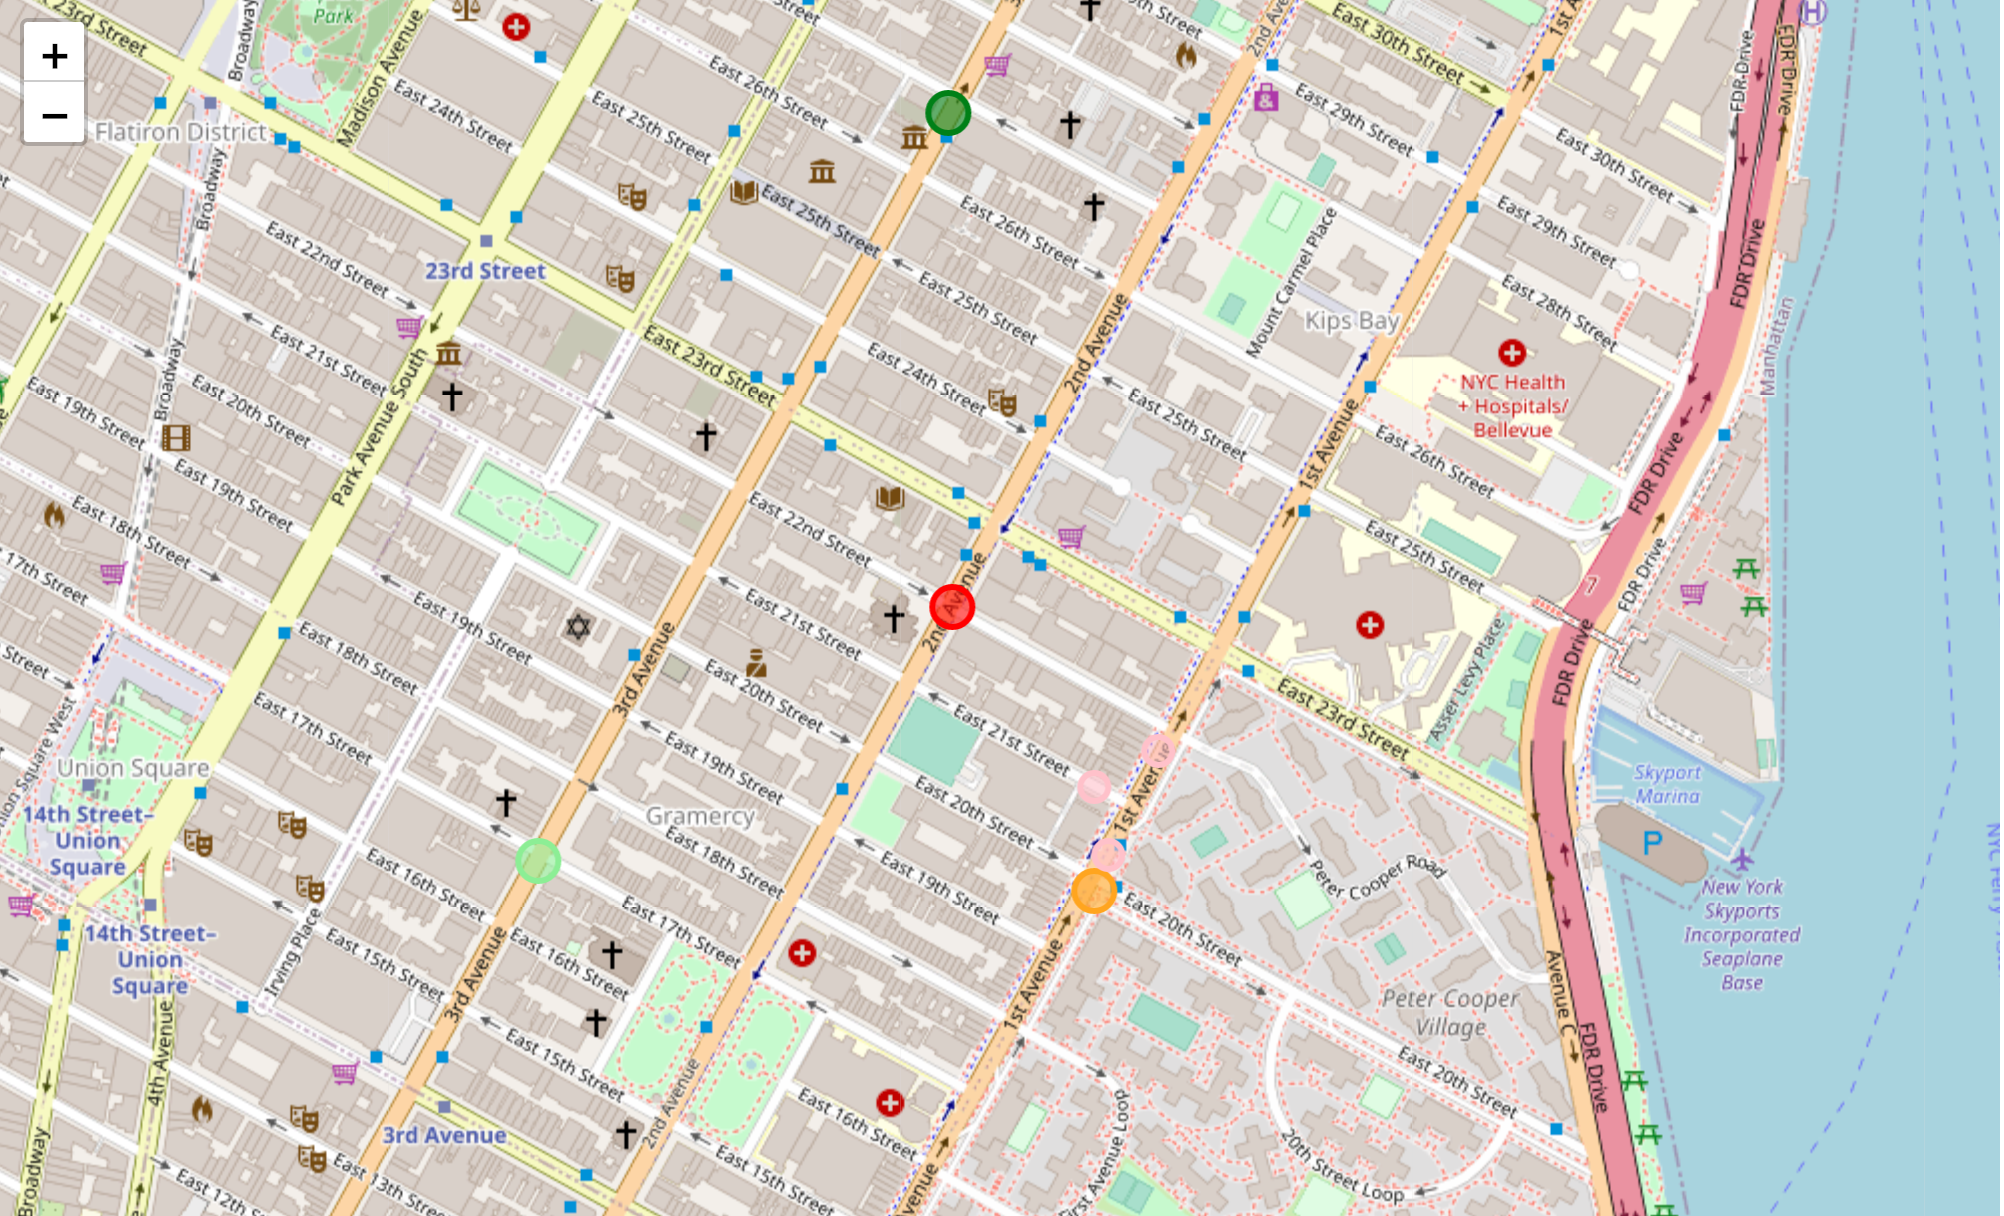

In [46]:
im = Image.open(r"/content/drive/My Drive/maps/gramercy-delivery.png")   
im
